In [2]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [3]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [4]:
alphas = ['.00001','.0001','.001','.01','.1','1','5']
versions = [1,2,3]
closs = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

In [23]:
import h5py
for ia, a in enumerate(alphas):
    for iv, v in enumerate(versions):
        log_error_rmse_file = "/home/bsb2144/directpose/tools/error_file_combined_full_batch_"+ str(v) +"_"+a+".h5"              
        with h5py.File(log_error_rmse_file, "r") as f:
            ks = list(f.keys())
            print(list(f.keys()))
            dset = f[ks[0]]
            closs[ia][iv] = dset[2500:10000]
            
                
its25_t0_10 = range(2500,10000)
print(closs)

['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls', 'loss_kps']
['combined_loss', 'heatmaps_loss', 'loss_centerness', 'loss_cls'

In [33]:
ca_00001 = []
#ca_0001 = []
#ca_001 = []
#ca_01 = []
#ca_p1 = []
#ca_1 = []
#ca_5 = []

i = 0
a = .00001
for v1, v2, v3 in zip(closs[i][0], closs[i][1], closs[i][2]):
    vaa = ((v1+v2+v3)/3)/a
    ca_00001.append(vaa)


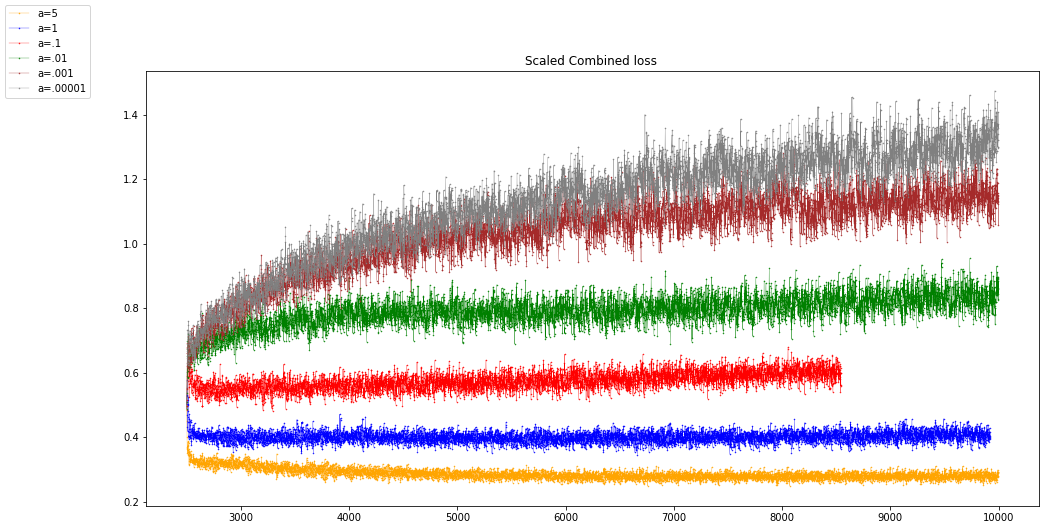

In [34]:

fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
ax.title.set_text("Scaled Combined loss ")
colors = ['r','b','y','g']

plt.plot(its25_t0_10, ca_5, '-o', c='orange', label="a=5",markersize=.5,linewidth=.3)
plt.plot(its25_t0_10, ca_1, '-o', c='blue', label="a=1",markersize=.5,linewidth=.3) 
plt.plot(its25_t0_10, ca_p1, '-o', c='red', label="a=.1",markersize=.5,linewidth=.3) 
plt.plot(its25_t0_10, ca_01, '-o', c='green', label="a=.01",markersize=.5,linewidth=.3) 
plt.plot(its25_t0_10, ca_001, '-o', c='brown', label="a=.001",markersize=.5,linewidth=.3) 
plt.plot(its25_t0_10, ca_00001, '-o', c='grey', label="a=.00001",markersize=.5,linewidth=.3) 
fig.legend(loc='upper left')
#fig.savefig("combo_st_sleap_un2" +'.png')
plt.show()